In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.4.1


In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
import numpy as np

from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time

In [2]:
!pip install tflocalpattern
from collections import Counter
from tflocalpattern.layers import LDP

In [13]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [15]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.701s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.066s


In [23]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.488s
Best estimator found by grid search:
SVC(C=69369.01511753422, class_weight='balanced', gamma=0.0025541821457348277)


In [30]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

In [27]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

TypeError: Invalid shape (1850,) for image data

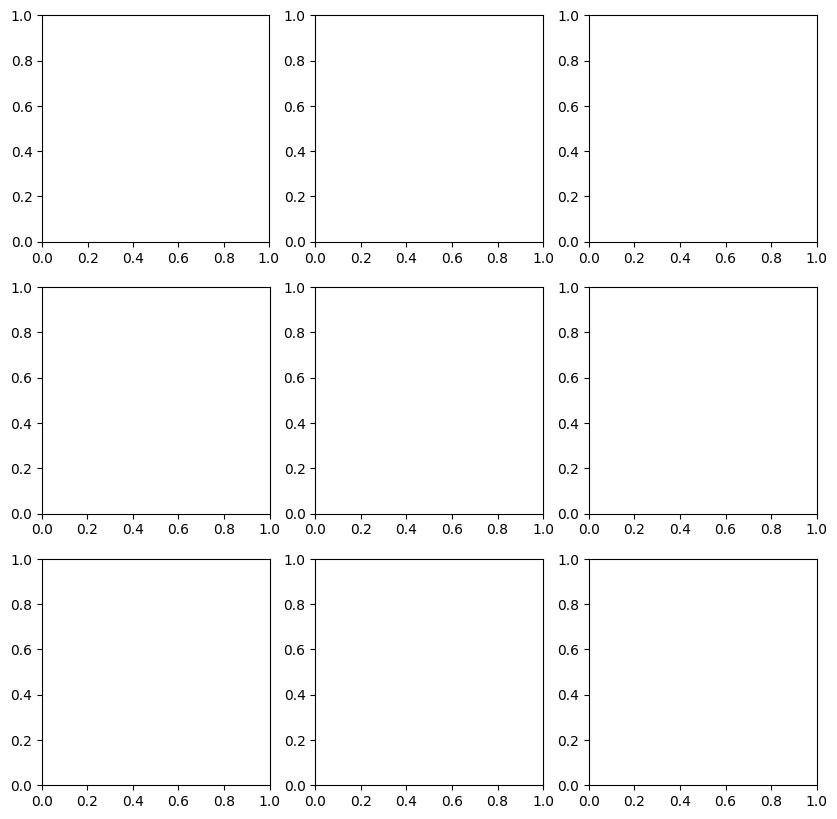

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[1])
    ax.axis('off')

plt.tight_layout()
plt.show()

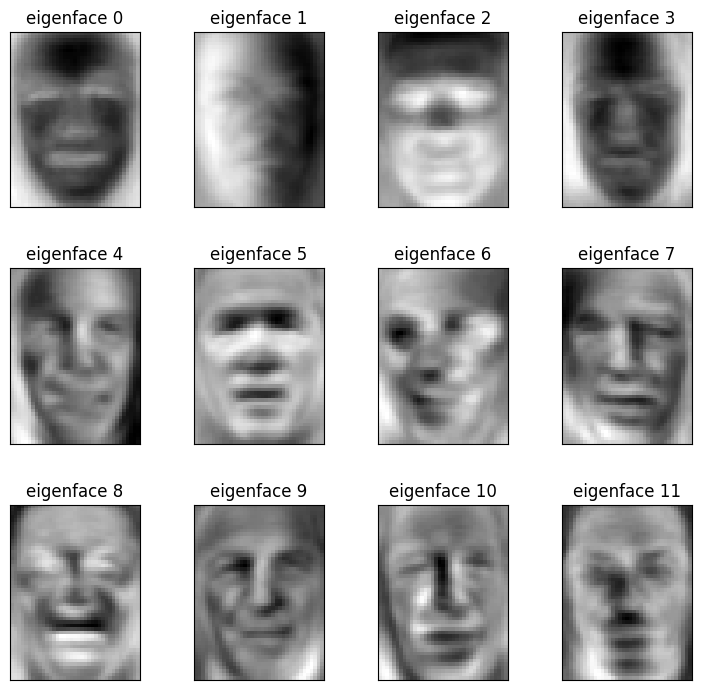

In [28]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()